In [28]:
import pandas as pd
import numpy as np
import dtale
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.metrics import classification_report,plot_confusion_matrix,plot_roc_curve,confusion_matrix
import pandas_profiling
import seaborn as sns

from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, make_union
from xgboost import XGBClassifier
from tpot.builtins import StackingEstimator
from tpot import TPOTClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier


%matplotlib inline

In [2]:
data = pd.read_csv("data/Phising_Training_Dataset.csv")

In [3]:
data.columns

Index(['key', 'having_IP', 'URL_Length', 'Shortining_Service',
       'having_At_Symbol', 'double_slash_redirecting', 'Prefix_Suffix',
       'having_Sub_Domain', 'SSLfinal_State', 'Domain_registeration_length',
       'Favicon', 'port', 'HTTPS_token', 'Request_URL', 'URL_of_Anchor',
       'Links_in_tags', 'SFH', 'Submitting_to_email', 'Abnormal_URL',
       'Redirect', 'on_mouseover', 'RightClick', 'popUpWidnow', 'Iframe',
       'age_of_domain', 'DNSRecord', 'web_traffic', 'Page_Rank',
       'Google_Index', 'Links_pointing_to_page', 'Statistical_report',
       'Result'],
      dtype='object')

## Data Exploration

In [4]:
data.corr()['Result']

key                           -0.000854
having_IP                      0.094027
URL_Length                     0.059331
Shortining_Service            -0.066170
having_At_Symbol               0.050045
double_slash_redirecting      -0.037758
Prefix_Suffix                  0.344660
having_Sub_Domain              0.296728
SSLfinal_State                 0.712543
Domain_registeration_length   -0.219960
Favicon                       -0.003260
port                           0.033971
HTTPS_token                   -0.036573
Request_URL                    0.254572
URL_of_Anchor                  0.696394
Links_in_tags                  0.238802
SFH                            0.217931
Submitting_to_email            0.011981
Abnormal_URL                  -0.059860
Redirect                      -0.027197
on_mouseover                   0.042180
RightClick                     0.004880
popUpWidnow                   -0.002868
Iframe                        -0.013429
age_of_domain                  0.135198


In [5]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
dtale.show(data)

## Model Building

In [141]:
X = data[data.columns[1:31]] 
y = data['Result']
enc = OneHotEncoder(handle_unknown='ignore')
X = pd.DataFrame(enc.fit_transform(X).toarray())

In [142]:
y.value_counts()

 1    5034
-1    3921
Name: Result, dtype: int64

In [112]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X,y)
dummy_clf.score(X, y)

0.56214405360134

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75, test_size=0.25)

In [70]:
pipeline_optimizer = TPOTClassifier(generations=5, population_size=20, cv=5,
                                    random_state=42, verbosity=2,scoring ='recall')
pipeline_optimizer.fit(X_train, y_train)

In [18]:
print(pipeline_optimizer.score(X_test, y_test))
pipeline_optimizer.export('tpot_exported_pipeline.py')

In [125]:
model = make_pipeline(
    StackingEstimator(estimator=XGBClassifier(learning_rate=0.5, max_depth=3, min_child_weight=4, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)),
    KNeighborsClassifier(n_neighbors=79, p=2, weights="distance")
)

In [126]:
model.fit(X_train,y_train)

Pipeline(steps=[('stackingestimator',
                 StackingEstimator(estimator=XGBClassifier(base_score=0.5,
                                                           booster='gbtree',
                                                           colsample_bylevel=1,
                                                           colsample_bynode=1,
                                                           colsample_bytree=1,
                                                           enable_categorical=False,
                                                           gamma=0, gpu_id=-1,
                                                           importance_type=None,
                                                           interaction_constraints='',
                                                           learning_rate=0.5,
                                                           max_delta_step=0,
                                                           max_depth=3,
                                                           min_child_weight=4,
                                                           missing=nan,
                                                           monotone_constraints='()',
                                                           n_estimators=100,
                                                           n_jobs=1,
                                                           num_parallel_tree=1,
                                                           predictor='auto',
                                                           random_state=0,
                                                           reg_alpha=0,
                                                           reg_lambda=1,
                                                           scale_pos_weight=1,
                                                           subsample=1.0,
                                                           tree_method='exact',
                                                           validate_parameters=1,
                                                           verbosity=0))),
                ('kneighborsclassifier',
                 KNeighborsClassifier(n_neighbors=79, weights='distance'))])

In [7]:
def print_scores(model,X_test,y_test):
    print(f"Accuracy: {model.score(X_test, y_test)}")
    print(classification_report(y_test,model.predict(X_test)))
    plot_confusion_matrix(model, X_test, y_test) 
    plot_roc_curve(model, X_test, y_test) 

Accuracy: 0.9696292987941045
              precision    recall  f1-score   support

          -1       0.97      0.96      0.97      1018
           1       0.97      0.98      0.97      1221

    accuracy                           0.97      2239
   macro avg       0.97      0.97      0.97      2239
weighted avg       0.97      0.97      0.97      2239



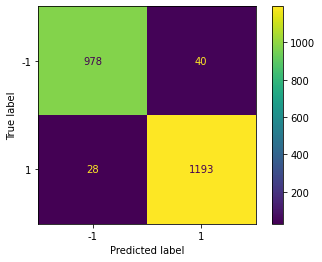

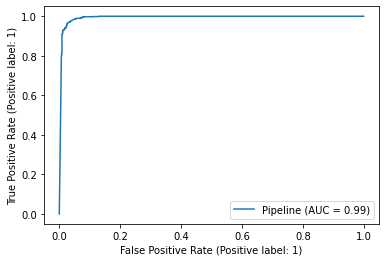

In [130]:
print_scores(model,X_test,y_test)

## Find and Eliminate dominant features

In [78]:
classifier = XGBClassifier(learning_rate=0.5, max_depth=3, min_child_weight=4, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)
classifier.fit(X_train,y_train)
feature_score = pd.DataFrame(zip(classifier.feature_importances_,enc.get_feature_names_out()),columns=['score','feature'])
feature_score.sort_values(by='score',ascending=False)

,score,feature
18,0.394855,SSLfinal_State_1
29,0.117567,URL_of_Anchor_-1
11,0.095129,Prefix_Suffix_-1
57,0.061307,web_traffic_0
30,0.033480,URL_of_Anchor_0
...,...,...
41,0.000000,Abnormal_URL_1
39,0.000000,Submitting_to_email_1
24,0.000000,port_1
26,0.000000,HTTPS_token_1


Two main features 
* SSLfinal_State
* URL_of_Anchor

## Build and Analyze model

In [4]:
data_mod = data.drop(['SSLfinal_State','URL_of_Anchor'],axis=1)
X = data_mod[data_mod.columns[1:29]] 
y = data_mod['Result']
enc = OneHotEncoder(handle_unknown='ignore')
X = pd.DataFrame(enc.fit_transform(X).toarray())

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.75, test_size=0.25)

In [48]:
params = {
 "learning_rate" : [0.05,0.10,0.15,0.20,0.25,0.30],
 "max_depth" : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma": [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 "n_estimators" : [100,150,200,250,300]
}

Accuracy: 0.8811969629298794
              precision    recall  f1-score   support

          -1       0.86      0.88      0.87      1003
           1       0.90      0.88      0.89      1236

    accuracy                           0.88      2239
   macro avg       0.88      0.88      0.88      2239
weighted avg       0.88      0.88      0.88      2239



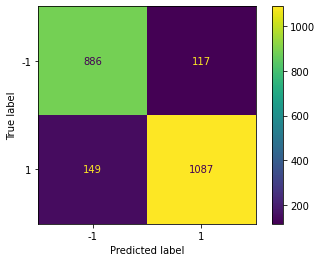

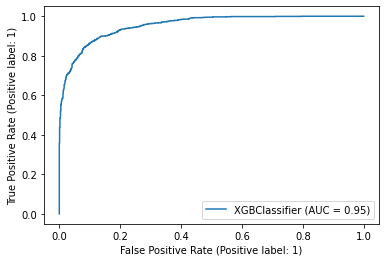

[CV 5/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=100;, score=0.932 total time=   2.6s
[CV 3/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=300;, score=0.909 total time=   5.6s
[CV 1/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=100;, score=0.930 total time=   2.7s
[CV 5/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=300;, score=0.929 total time=   5.6s


/Users/rajagopalps/mlenv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constru

[CV 3/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=100;, score=0.917 total time=   2.7s
[CV 1/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=250;, score=0.939 total time=   7.4s
[CV 2/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=100;, score=0.910 total time=   2.7s
[CV 2/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=250;, score=0.920 total time=   7.4s


/Users/rajagopalps/mlenv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constru

[CV 5/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=300;, score=0.929 total time=   6.8s
[CV 1/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=150;, score=0.938 total time=   3.6s
[CV 3/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=300;, score=0.914 total time=   6.8s
[CV 4/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=150;, score=0.904 total time=   3.6s


/Users/rajagopalps/mlenv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constru

[CV 4/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=300;, score=0.897 total time=   6.8s
[CV 2/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=150;, score=0.916 total time=   3.7s
[CV 2/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=300;, score=0.914 total time=   6.8s
[CV 3/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=150;, score=0.917 total time=   3.7s


/Users/rajagopalps/mlenv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constru

[CV 4/5] END colsample_bytree=0.4, gamma=0.2, learning_rate=0.3, max_depth=15, min_child_weight=3, n_estimators=100;, score=0.900 total time=   2.6s
[CV 4/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=300;, score=0.895 total time=   5.5s
[CV 5/5] END colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=150;, score=0.937 total time=   3.5s


/Users/rajagopalps/mlenv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constru

[CV 2/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=300;, score=0.917 total time=   5.5s
[CV 3/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=250;, score=0.914 total time=   6.2s
[CV 1/5] END colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=15, min_child_weight=7, n_estimators=300;, score=0.930 total time=   5.6s
[CV 4/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=250;, score=0.897 total time=   6.2s


/Users/rajagopalps/mlenv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constru

[CV 1/5] END colsample_bytree=0.7, gamma=0.3, learning_rate=0.2, max_depth=6, min_child_weight=5, n_estimators=300;, score=0.933 total time=   6.6s
[CV 5/5] END colsample_bytree=0.7, gamma=0.4, learning_rate=0.15, max_depth=8, min_child_weight=1, n_estimators=250;, score=0.928 total time=   6.1s


/Users/rajagopalps/mlenv/lib/python3.8/site-packages/pandas/compat/__init__.py:124: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/rajagopalps/mlenv/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constru

In [63]:
model=XGBClassifier(learning_rate=0.5, max_depth=3, min_child_weight=4, n_estimators=100, n_jobs=1, verbosity=0)
model.fit(X_train,y_train)
print_scores(model,X_test,y_test)

In [50]:
random_cv=RandomizedSearchCV(model,param_distributions=params,n_iter=5,scoring='recall',n_jobs=-1,cv=5,verbose=3)
random_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=0.5,
                                           max_delta_step=None, max_depth=3,
                                           min_child_weight=4, missing=nan,
                                           monotone_constraints=None,
                                           n...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                           validate_parameters=None,
                                           verbosity=0),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.3, 0.4, 0.5,
                                                             0.7],
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [3, 4, 5, 6, 8, 10, 12,
                                                      15],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 150, 200, 250,
                                                         300]},
                   scoring='recall', verbose=3)

In [51]:
random_cv.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.25, max_delta_step=0, max_depth=10,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=150, n_jobs=1, num_parallel_tree=1, predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=0)

Accuracy: 0.915587315765967
              precision    recall  f1-score   support

          -1       0.91      0.91      0.91      1003
           1       0.92      0.92      0.92      1236

    accuracy                           0.92      2239
   macro avg       0.91      0.91      0.91      2239
weighted avg       0.92      0.92      0.92      2239



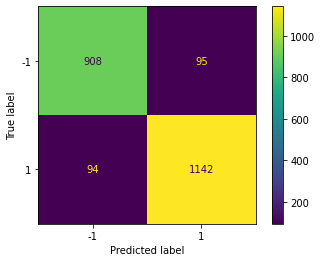

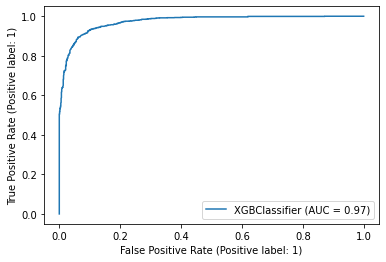

In [64]:
model=XGBClassifier(learning_rate=0.25, max_depth=10, min_child_weight=3, n_estimators=150,colsample_bytree=0.5, n_jobs=1, verbosity=0)
model.fit(X_train,y_train)
print_scores(model,X_test,y_test)

In [53]:
model.fit(X_train,y_train)
feature_score = pd.DataFrame(zip(clf.feature_importances_,enc.get_feature_names_out()),columns=['score','feature'])
feature_score.sort_values(by='score',ascending=False)

,score,feature
11,0.191751,Prefix_Suffix_-1
15,0.186650,having_Sub_Domain_1
52,0.105230,web_traffic_1
26,0.045866,Links_in_tags_-1
29,0.037472,SFH_-1
...,...,...
19,0.000000,Favicon_1
17,0.000000,Domain_registeration_length_1
8,0.000000,having_At_Symbol_1
12,0.000000,Prefix_Suffix_1


## Prediction

In [54]:
test = pd.read_csv("data/Phising_Testing_Dataset.csv")
test = test.drop(['SSLfinal_State','URL_of_Anchor'],axis=1)

In [55]:
# X_pred = test[test.columns[1:31]]
X_pred = test[test.columns[1:29]]

In [56]:
X_pred = pd.DataFrame(enc.transform(X_pred).toarray())

In [57]:
res = test[['key']]
res['Result']= model.predict(X_pred)

In [58]:
res.to_csv('data/Phishing_Submission.csv',index=False)

## Compare predictions

In [59]:
res_old = pd.read_csv('data/Phishing_Submission_old.csv')

In [60]:
cm =confusion_matrix(res_old['Result'],res['Result'])

<AxesSubplot:>

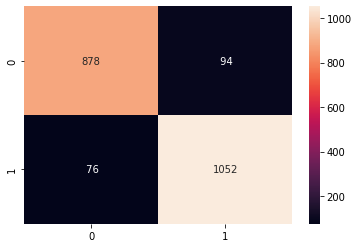

In [61]:
sns.heatmap(cm,annot=True,fmt="3g")

In [62]:
print(classification_report(res['Result'],res_old['Result']))

              precision    recall  f1-score   support

          -1       0.90      0.92      0.91       954
           1       0.93      0.92      0.93      1146

    accuracy                           0.92      2100
   macro avg       0.92      0.92      0.92      2100
weighted avg       0.92      0.92      0.92      2100

